In [6]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
import os
os.chdir('/content/drive/MyDrive/Colab Notebooks/AI Project')

In [8]:
# Import neccessary library
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow import keras
from keras import callbacks
from keras import layers, models
from keras.applications import MobileNetV2
from keras.applications.mobilenet_v2 import preprocess_input

In [4]:
%pip install tensorflow_datasets==4.9.3

In [ ]:
(train_raw, val_raw, test_raw), ds_info = tfds.load(name='oxford_iiit_pet',
                                                    split=['train[:80%]',
                                                          'train[80%:]',
                                                          'test'],
                                                    shuffle_files=True,
                                                    as_supervised=True, # Returns (image, label)
                                                    with_info=True # To retrieve dataset info and label names
                                                    )

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

In [9]:
IMG_SIZE = 224

# Resize images
def resize(image, label):
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    return image, label

train_ds = train_raw.map(resize)
val_ds = val_raw.map(resize)
test_ds = test_raw.map(resize)

In [10]:
# Encoding the target label
def one_hot_encode(image, label):
    label = tf.one_hot(label, num_classes)
    return image, label

In [11]:
num_classes = 37

train_ds = train_ds.map(one_hot_encode)
val_ds = val_ds.map(one_hot_encode)
test_ds = test_ds.map(one_hot_encode)

In [12]:
data_augmentation = keras.Sequential(
    [layers.RandomFlip('horizontal'),
     layers.RandomRotation(factor=(-0.025, 0.025)),
     layers.RandomTranslation(height_factor=0.1, width_factor=0.1),
     layers.RandomContrast(factor=0.1),
     ])

In [13]:
BATCH_SIZE = 32

In [14]:
train_ds = train_ds.cache().shuffle(1000).batch(batch_size=BATCH_SIZE,
                          drop_remainder=True).prefetch(tf.data.AUTOTUNE)

val_ds = val_ds.cache().shuffle(1000).batch(batch_size=BATCH_SIZE,
                      drop_remainder=True).prefetch(tf.data.AUTOTUNE)

test_ds = test_ds.cache().shuffle(1000).batch(batch_size=BATCH_SIZE,
                        drop_remainder=True).prefetch(tf.data.AUTOTUNE)

In [15]:
IMG_SIZE = 224

base_model = keras.applications.MobileNetV2(input_shape=(IMG_SIZE, IMG_SIZE, 3),
                                            include_top=False, weights="imagenet")

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [16]:
# Freeze the base_model
base_model.trainable = False

In [17]:
# Create new model on top
inputs = keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
x = data_augmentation(inputs)

In [18]:
x = keras.applications.mobilenet_v2.preprocess_input(x)

In [19]:
x = base_model(x, training=False)

In [20]:
x.shape

(None, 7, 7, 1280)

In [21]:
# Rebuild top layers
x = layers.GlobalAveragePooling2D()(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.2)(x)  # Regularize with dropout

outputs = layers.Dense(num_classes, activation="softmax", name="pred")(x)

model = keras.Model(inputs, outputs)

In [22]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential (Sequential)              │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ true_divide (TrueDivide)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ subtract (Subtract)                  │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ mobilenetv2_1.00_224 (Functional)    │ (None, 7, 7, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 1280)                │           5,120 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1280)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ pred (Dense)                         │ (None, 37)                  │          47,397 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,310,501 (8.81 MB)

 Trainable params: 49,957 (195.14 KB)

 Non-trainable params: 2,260,544 (8.62 MB)

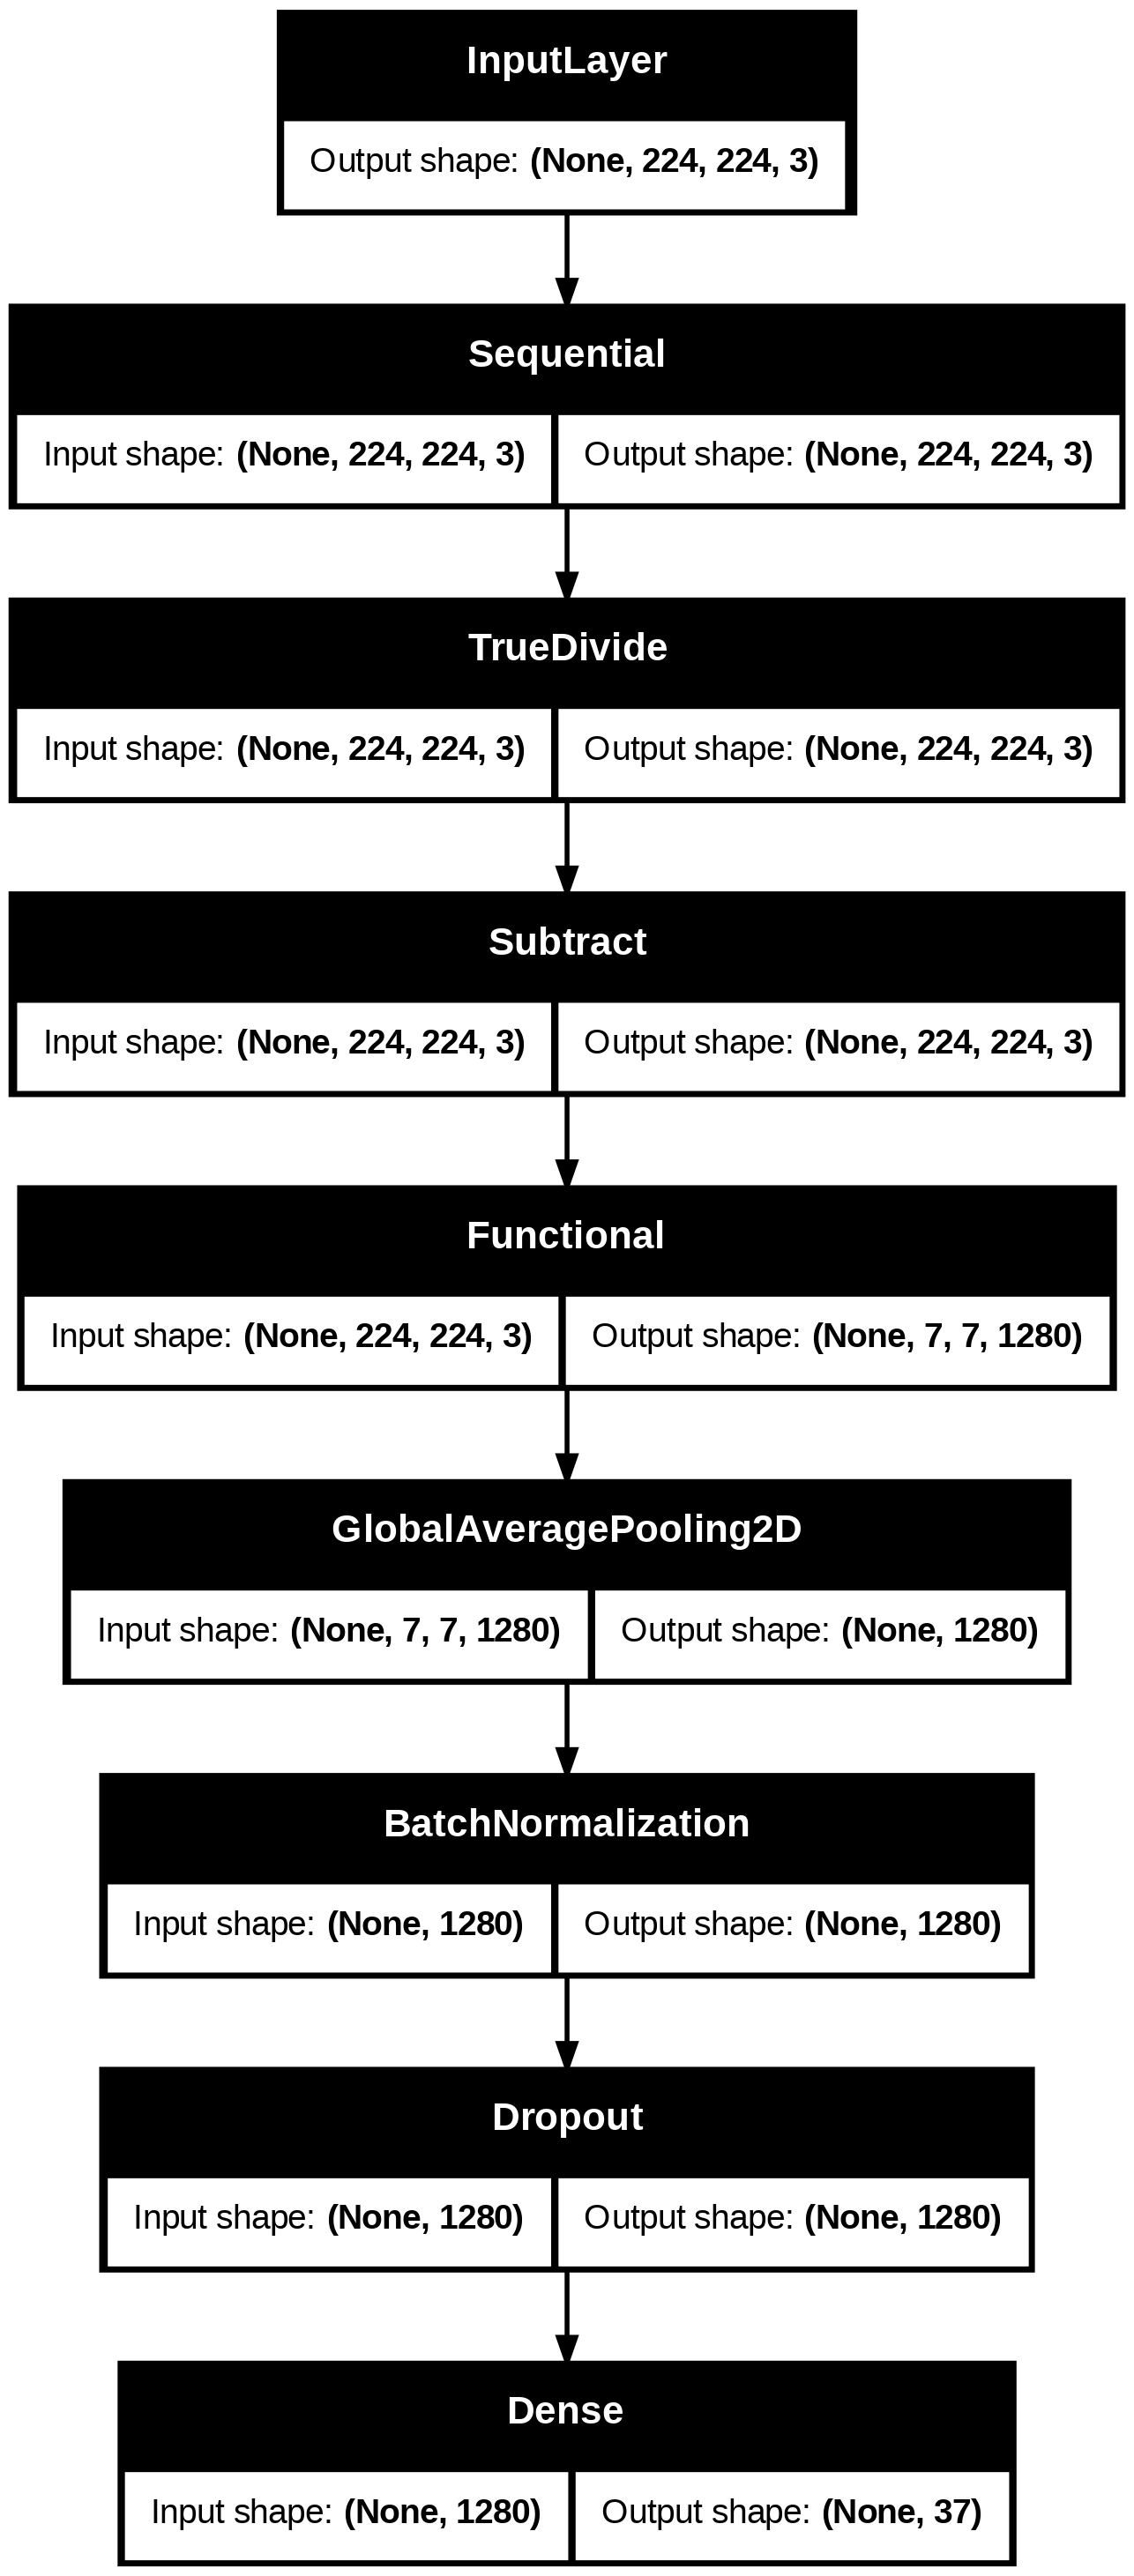

In [23]:
keras.utils.plot_model(model, show_shapes=True)

In [24]:
model.compile(optimizer=keras.optimizers.Adam(),
              loss=keras.losses.CategoricalCrossentropy(),
              metrics=[keras.metrics.CategoricalAccuracy()]
             )

In [25]:
earlystopping = callbacks.EarlyStopping(monitor='val_loss',
                                        mode='min',
                                        patience=5,
                                        restore_best_weights=True)

In [26]:
EPOCHS = 20

history = model.fit(train_ds, epochs=EPOCHS, validation_data=val_ds, verbose=1,
                    callbacks =[earlystopping])

Epoch 1/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 41s 257ms/step - categorical_accuracy: 0.4129 - loss: 2.2806 - val_categorical_accuracy: 0.8560 - val_loss: 0.6031
Epoch 2/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 16s 98ms/step - categorical_accuracy: 0.8629 - loss: 0.4044 - val_categorical_accuracy: 0.8845 - val_loss: 0.3783
Epoch 3/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 7s 77ms/step - categorical_accuracy: 0.9049 - loss: 0.2823 - val_categorical_accuracy: 0.8886 - val_loss: 0.3327
Epoch 4/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 7s 76ms/step - categorical_accuracy: 0.9281 - loss: 0.2217 - val_categorical_accuracy: 0.8927 - val_loss: 0.3316
Epoch 5/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 11s 82ms/step - categorical_accuracy: 0.9406 - loss: 0.1757 - val_categorical_accuracy: 0.8859 - val_loss: 0.3302
Epoch 6/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 7s 79ms/step - categorical_accuracy: 0.9495 - loss: 0.1423 - val_categorical_accuracy: 0.8832 - val_loss: 0.3570
Epoch 7/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 8s 91ms/step - categorical_accuracy: 0.9634 - loss: 

In [27]:
model.save('Models/MobileNet_V2.keras')

In [28]:
preds_mobilenet = model.predict(test_ds)

114/114 ━━━━━━━━━━━━━━━━━━━━ 15s 81ms/step


In [29]:
result_mobilenet = model.evaluate(test_ds)

114/114 ━━━━━━━━━━━━━━━━━━━━ 7s 58ms/step - categorical_accuracy: 0.8894 - loss: 0.3557


In [30]:
dict(zip(model.metrics_names, result_mobilenet))

{'loss': 0.3843810558319092, 'compile_metrics': 0.8832237124443054}

In [35]:
from sklearn.metrics import classification_report, confusion_matrix
from seaborn import heatmap
import seaborn as sns

In [32]:
# Assuming 'model' is your trained model and 'test_ds' is your test dataset
y_true = []
y_pred = []

for images, labels in test_ds:
    predictions = model.predict(images)
    y_true.extend(np.argmax(labels.numpy(), axis=1))
    y_pred.extend(np.argmax(predictions, axis=1))

# Convert to numpy arrays
y_true = np.array(y_true)
y_pred = np.array(y_pred)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━

In [33]:
y_pred

array([30, 32, 33, ..., 27, 22, 24])

Classification Report:
                             precision    recall  f1-score   support

                Abyssinian       0.75      0.91      0.82        98
          american_bulldog       0.64      0.91      0.75       100
 american_pit_bull_terrier       0.80      0.49      0.61        99
              basset_hound       0.94      0.94      0.94       100
                    beagle       0.90      0.87      0.88       100
                    Bengal       0.81      0.78      0.79        99
                    Birman       0.69      0.85      0.76       100
                    Bombay       0.93      0.79      0.86        87
                     boxer       0.83      0.88      0.85        97
         British_Shorthair       0.76      0.79      0.77        99
                 chihuahua       0.92      0.93      0.93       100
              Egyptian_Mau       0.93      0.78      0.85        97
    english_cocker_spaniel       0.96      0.94      0.95       100
            english_set

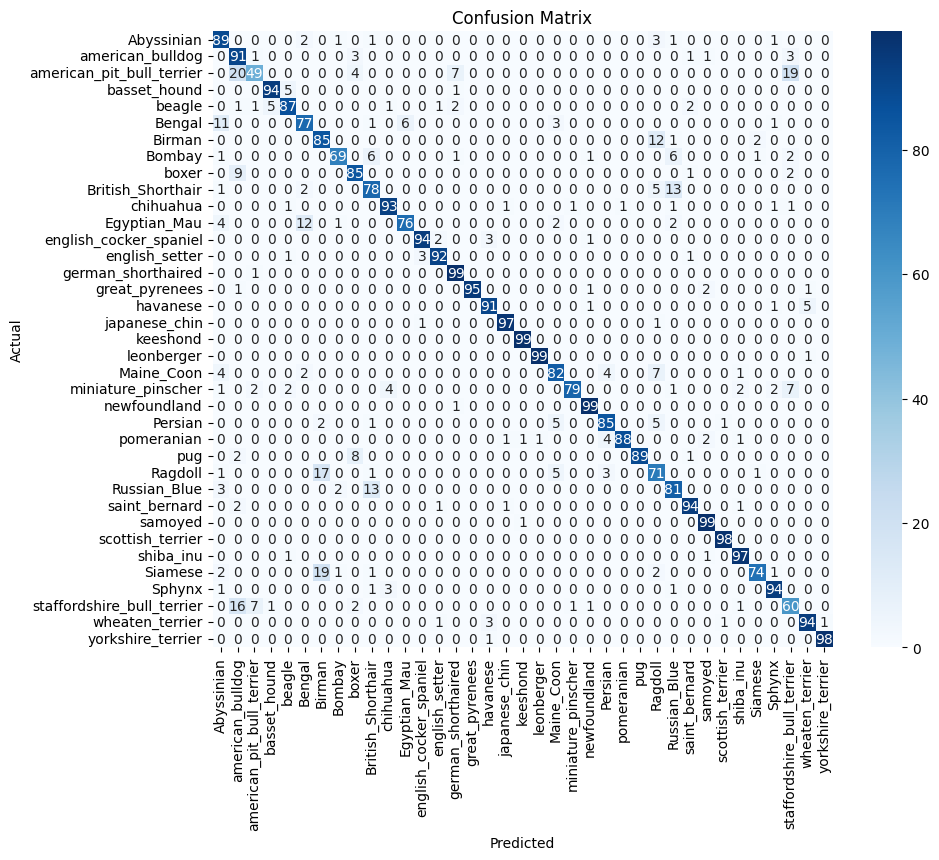

In [36]:
# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Print the classification report
class_names = ds_info.features['label'].names  # Ensure this list is available or manually define it
class_report = classification_report(y_true, y_pred, target_names=class_names)
print('Classification Report:\n', class_report)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [37]:
from sklearn.metrics import accuracy_score, mean_absolute_error, mean_squared_error, f1_score

# Assuming y_true are the true labels/values and y_pred are the predicted labels/values
accuracy = accuracy_score(y_true, y_pred)
mae = mean_absolute_error(y_true, y_pred)
rmse = mean_squared_error(y_true, y_pred, squared=False)  # squared=False returns RMSE
f1 = f1_score(y_true, y_pred, average='weighted')

print("Accuracy:", accuracy)
print("MAE:", mae)
print("RMSE:", rmse)
print("F1 Score:", f1)

Accuracy: 0.8829495614035088
MAE: 1.7341008771929824
RMSE: 6.142407237123461
F1 Score: 0.8829002310472756


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


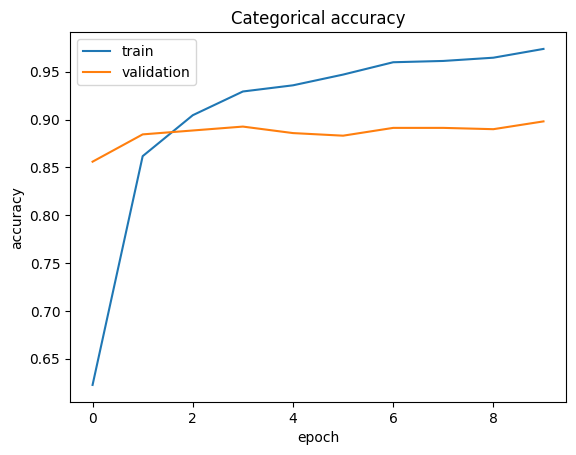

In [38]:
def plot_hist(hist):
    plt.plot(hist.history['categorical_accuracy'])
    plt.plot(hist.history['val_categorical_accuracy'])
    plt.title('Categorical accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

plot_hist(history)

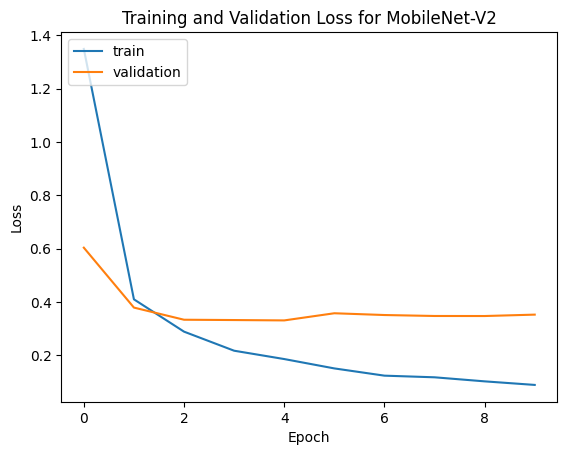

In [39]:
def plot_loss(hist):
    plt.plot(hist.history['loss'])
    plt.plot(hist.history['val_loss'])
    plt.title('Training and Validation Loss for MobileNet-V2')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

plot_loss(history)

### Test on new instances

In [40]:
from keras.preprocessing import image

# Load the saved model
loaded_model = keras.models.load_model('Models/MobileNet_V2.keras')

# Function to preprocess the uploaded image
def preprocess_image(img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    plt.imshow(img_array/255)
    img_array = np.expand_dims(img_array, axis=0)  # Expand dimensions to match model input shape
    return img_array

# Function to make predictions
def predict_image(img_array):
    predictions = loaded_model.predict(img_array)
    predicted_class = np.argmax(predictions[0])  # Get the index of the class with highest probability
    return predicted_class

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Predicted class index: 10
Predicted class: chihuahua


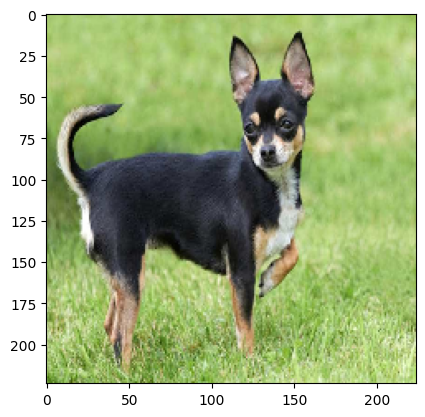

In [41]:
uploaded_file_path = "Samples/chihuahua.jpg"

# Preprocess the uploaded image
preprocessed_img = preprocess_image(uploaded_file_path)

class_names = ds_info.features['label'].names

# Make predictions
predicted_class = predict_image(preprocessed_img)

# Display the prediction
print("Predicted class index:", predicted_class)

# Function to map class index to class name
def get_class_name(class_index):
    return class_names[class_index]

# Example usage:
predicted_class_name = get_class_name(predicted_class)

# Print the actual name of the predicted class
print("Predicted class:", predicted_class_name)